In [8]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tools
from IPython.display import clear_output
import copy
import sys
import importlib

# Specialized packages
from casadi import *
from casadi.tools import *

# Plotting
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
from cycler import cycler
import time as time
# Visualization
from mpl_toolkits.mplot3d import Axes3D

# Control packages
import do_mpc
import control



In [9]:
import importlib

import CSTRmodel
importlib.reload(CSTRmodel)

cstr = CSTRmodel.CSTR_Cascade(n_reac=4)
#qc = qcmodel.BiasedQuadcopter()
#qc = qcmodel.MeasuredBiasedQuadcopter()
# qc = qcmodel.WeightUncertainQuadcopter()

cstr.get_model()

# Simulator

In [16]:
import CSTRcontrol
importlib.reload(CSTRcontrol)
simulator=CSTRcontrol.get_simulator(t_step=1,CSTR=cstr)

# Controller

Just some basic MPC

In [20]:
import CSTRcontrol
importlib.reload(CSTRcontrol)
mpc, mpc_tvp_template=CSTRcontrol.get_MPC(t_step=1,CSTR=cstr)

# Run Closed Loop

In [45]:
sim_tvp_template=simulator.get_tvp_template()
sim_tvp_template['k1']=cstr.k1_0
sim_tvp_template['k2']=cstr.k2_0
sim_tvp_template['delH1']=cstr.delH1_0
sim_tvp_template['delH2']=cstr.delH2_0
simulator.set_tvp_fun(lambda t: sim_tvp_template)
simulator.setup()

In [46]:
tvp=np.zeros((cstr.np,1))
tvp[0:cstr.n_reac]=cstr.k1_0
tvp[cstr.n_reac:2*cstr.n_reac]=cstr.k2_0
tvp[2*cstr.n_reac:3*cstr.n_reac]=cstr.delH1_0
tvp[3*cstr.n_reac:4*cstr.n_reac]=cstr.delH2_0

for i in range(len(mpc_tvp_template['_tvp'])):
    mpc_tvp_template['_tvp',]=tvp

def mpc_tvp_fun(t_now):
    return mpc_tvp_template

mpc.set_tvp_fun(mpc_tvp_fun)

mpc.setup()


In [47]:
mpc.reset_history()
simulator.reset_history()
x_0=0*np.ones((cstr.nx,1))
x_0[-cstr.n_reac:]=cstr.Tr_in
mpc.x0 = x_0



mpc.set_initial_guess()
simulator.x0 = x_0

x0 = simulator.x0

In [48]:
N_iter = 60
for k in range(N_iter):
    CSTRmodel.print_progress(k,N_iter)
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)
    
mpc_res = copy.copy(mpc.data)

Text(0.5, 0, 'time')

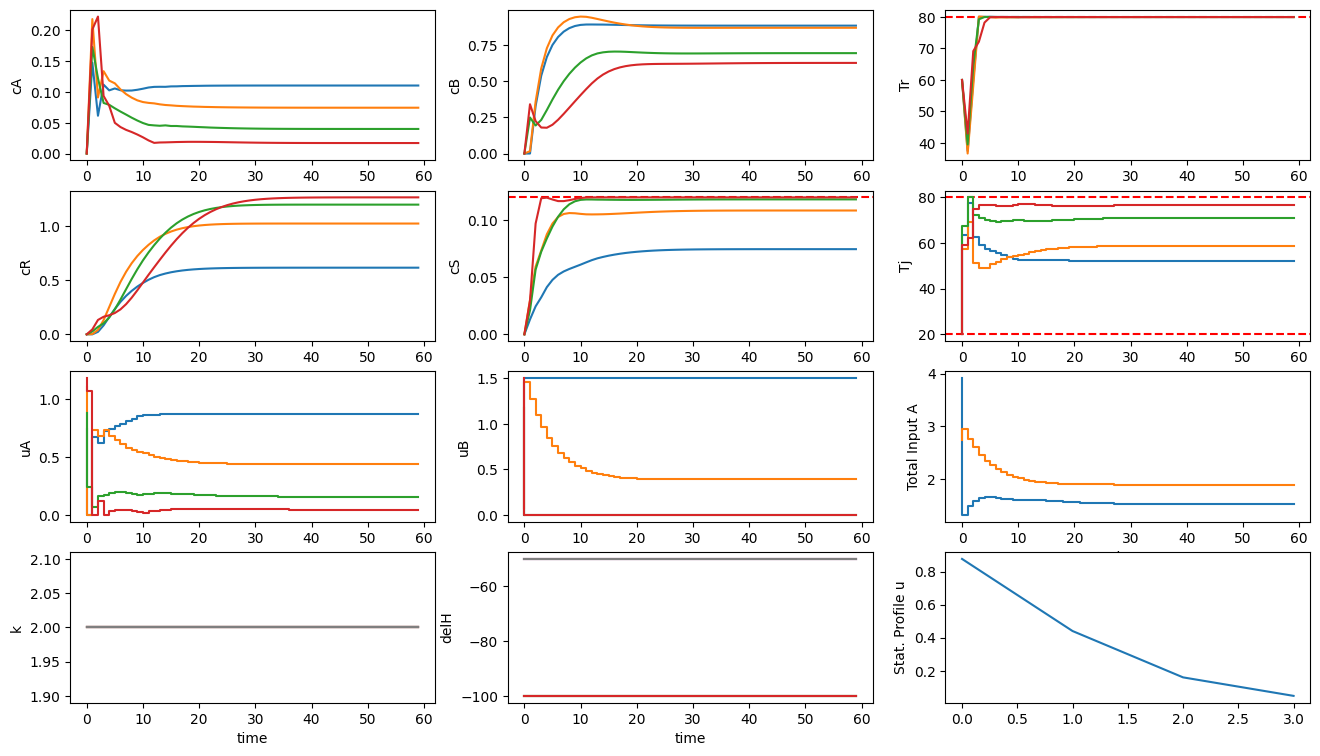

In [49]:
# plot the states
fig, ax = plt.subplots(4,3, sharex=False,sharey=False,figsize=(16,9))
ax[1,1].axhline(y=0.12,linestyle='--',color='red')
ax[0,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=20,linestyle='--',color='red')
ax[0,0].plot(mpc_res['_time'],mpc_res['_x','cA'])
ax[0,1].plot(mpc_res['_time'],mpc_res['_x','cB'])
ax[1,0].plot(mpc_res['_time'],mpc_res['_x','cR'])
ax[1,1].plot(mpc_res['_time'],mpc_res['_x','cS'])
ax[0,2].plot(mpc_res['_time'],mpc_res['_x','Tr'])
ax[1,2].step(mpc_res['_time'],mpc_res['_u','Tj'])
ax[2,0].step(mpc_res['_time'],mpc_res['_u','uA'])
ax[2,1].step(mpc_res['_time'],mpc_res['_u','uB'])
ax[2,2].step(mpc_res['_time'],np.sum(mpc_res['_u','uA'],axis=1))
ax[2,2].step(mpc_res['_time'],np.sum(mpc_res['_u','uB'],axis=1))
ax[3,2].plot(np.arange(cstr.n_reac),mpc_res['_u','uA'][-1,:])
ax[3,0].step(mpc_res['_time'],mpc_res['_tvp','k1'])
ax[3,0].step(mpc_res['_time'],mpc_res['_tvp','k2'])
ax[3,1].step(mpc_res['_time'],mpc_res['_tvp','delH1'])
ax[3,1].step(mpc_res['_time'],mpc_res['_tvp','delH2'])

# Set labels
ax[0,0].set_ylabel('cA')
ax[0,1].set_ylabel('cB')
ax[1,0].set_ylabel('cR')
ax[1,1].set_ylabel('cS')
ax[2,0].set_ylabel('uA')
ax[2,1].set_ylabel('uB')
ax[0,2].set_ylabel('Tr')
ax[1,2].set_ylabel('Tj')
#ax[1,2].set_ylim([0,1])
ax[2,2].set_ylabel('Total Input A')
ax[3,2].set_ylabel('Stat. Profile u')
ax[3,0].set_ylabel('k')
ax[3,1].set_ylabel('delH')
ax[3,0].set_xlabel('time')
ax[3,1].set_xlabel('time')
ax[2,2].set_xlabel('time')